In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor
import os

In [2]:
df = pd.read_csv(r"C:\Users\adamk\Desktop\car-sales-forecast\data\monthly-car-sales.csv")

In [3]:
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [4]:
# Ensure Month column is datetime
df["Month"] = pd.to_datetime(df["Month"])

# Sort chronologically
df = df.sort_values(by="Month")

# Create 6 lag features
for i in range(1, 7):
    df[f"Sales_Lag_{i}"] = df["Sales"].shift(i)

df.head(10)


,Month,Sales,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5,Sales_Lag_6
0,1960-01-01,6550,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728,6550.0,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026,8728.0,6550.0,NaN,NaN,NaN,NaN
3,1960-04-01,14395,12026.0,8728.0,6550.0,NaN,NaN,NaN
4,1960-05-01,14587,14395.0,12026.0,8728.0,6550.0,NaN,NaN
5,1960-06-01,13791,14587.0,14395.0,12026.0,8728.0,6550.0,NaN
6,1960-07-01,9498,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
7,1960-08-01,8251,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
8,1960-09-01,7049,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
9,1960-10-01,9545,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0


In [ ]:
# Check for missingness
df.isna().sum()

Month          0
Sales          0
Sales_Lag_1    1
Sales_Lag_2    2
Sales_Lag_3    3
Sales_Lag_4    4
Sales_Lag_5    5
Sales_Lag_6    6
dtype: int64

In [9]:
# Drop everything
df = df.dropna().reset_index(drop=True)

df.isna().sum()



Month          0
Sales          0
Sales_Lag_1    0
Sales_Lag_2    0
Sales_Lag_3    0
Sales_Lag_4    0
Sales_Lag_5    0
Sales_Lag_6    0
dtype: int64

In [ ]:
# Target variable: actual sales numbers
y = df["Sales"]

# Features: all lag columns (drop Sales + Month)
X = df.drop(["Sales", "Month"], axis=1)



In [16]:
# TimeSeriesSplit is required for forecasting to avoid data leakage
# It ensures earlier months train the model and later months validate it
tscv = TimeSeriesSplit(n_splits=3)

# Base model with squared error loss
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)


In [17]:
# Grid of parameters to test in GridSearchCV
# These values affect accuracy and overfitting/underfitting
param_grid = {
    "n_estimators": [200, 400],      # number of trees
    "learning_rate": [0.05, 0.1],    # how fast the model learns
    "max_depth": [3, 5, 7],          # tree complexity
    "subsample": [0.8, 1.0],         # % of rows used
    "colsample_bytree": [0.8, 1.0]   # % of columns used
}



In [18]:

# GridSearch tests every parameter combination using TimeSeriesSplit
# It chooses the set that minimizes RMSE (highest accuracy)
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=tscv,                 # time-series aware splits
    scoring="neg_root_mean_squared_error",  # minimize RMSE
    n_jobs=-1,               # use all CPU cores
    verbose=1                # print progress
)

# Fit the grid search model to data
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1.0}
Best RMSE: 3409.403564453125


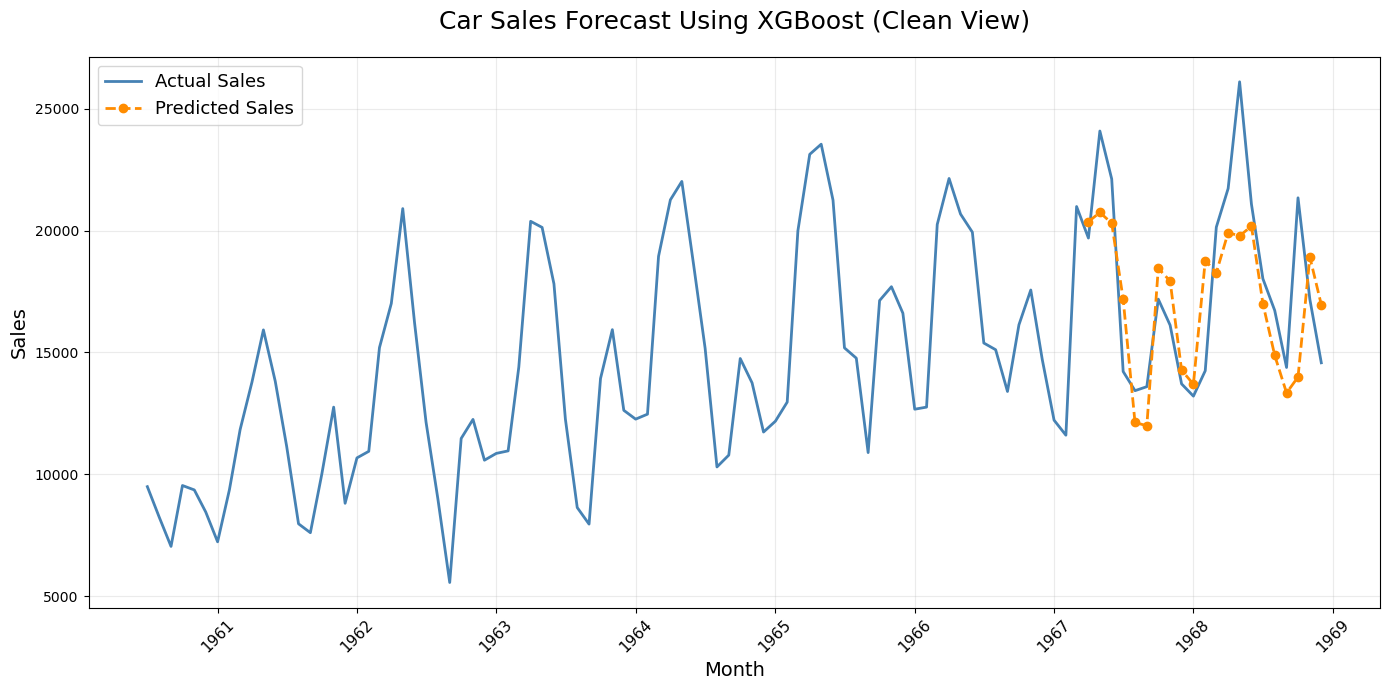

In [22]:
plt.figure(figsize=(14, 7))

# Plot actual historical data (all months)
plt.plot(df["Month"], df["Sales"], 
         color="steelblue", linewidth=2, label="Actual Sales")

# Plot predicted values only inside the test period
plt.plot(df["Month"].iloc[split_idx:], preds,
         color="darkorange", linewidth=2, linestyle="--",
         marker="o", markersize=6, label="Predicted Sales")

# Title and labels
plt.title("Car Sales Forecast Using XGBoost (Clean View)", fontsize=18, pad=20)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Sales", fontsize=14)

# Improve look of x-axis labels
plt.xticks(rotation=45, fontsize=11)

# Add a slightly lighter grid for readability
plt.grid(alpha=0.25)

# Legend
plt.legend(fontsize=13)

plt.tight_layout()
plt.show()


In [25]:
import altair as alt
import pandas as pd

# Build tidy dataframe
plot_df = pd.DataFrame({
    "Month": df["Month"].iloc[split_idx:],
    "Actual_Sales": y_test.values,
    "Predicted_Sales": preds
})

# Melt into long format
plot_df_melted = plot_df.melt("Month", var_name="Series", value_name="Sales")

# Altair chart with formatted dates
chart = (
    alt.Chart(plot_df_melted)
    .mark_line(point=True)
    .encode(
        x=alt.X(
            "Month:T",
            title="Month",
            axis=alt.Axis(
                format="%Y-%m",       # <<— This makes the axis YYYY-MM
                labelAngle=-45       # rotate labels for readability
            )
        ),
        y=alt.Y("Sales:Q", title="Sales"),
        color=alt.Color(
            "Series:N",
            scale=alt.Scale(range=["#003f5c", "#ffa600"]),
            title="Legend"
        ),
        tooltip=[
            alt.Tooltip("Month:T", format="%Y-%m"),
            "Series:N",
            alt.Tooltip("Sales:Q", format=",")  # comma formatting (ex: 21,000)
        ]
    )
    .properties(
        title="Actual vs Predicted Car Sales (XGBoost Model)",
        width=900,
        height=400
    )
    .interactive()
)

chart


alt.Chart(...)

In [26]:
# Retrain the best model on the full dataset
print("Training final XGBoost model on full data...")
best_model.fit(X, y)

# Ensure model directory exists
os.makedirs("model", exist_ok=True)

# Save the final model in JSON format (Render-friendly)
save_path = "model/model.json"
best_model.get_booster().save_model(save_path)

print(f"Final model saved successfully at: {save_path}")


Training final XGBoost model on full data...
Final model saved successfully at: model/model.json
